In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from model import GalerkinSARIMA
import time
import warnings


In [2]:

warnings.filterwarnings("ignore")
np.random.seed(123)

csv_path = "FRED.csv"
target_col = "INDPRO"
m_seasonal = 5

def _pick_date_col(df: pd.DataFrame) -> str:
    for c in ["sasdate", "DATE", "date", "Date"]:
        if c in df.columns:
            return c
    return df.columns[0]

def _to_stationary(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    if (x > 0).all():
        return (100.0 * np.log(x)).diff().dropna()
    else:
        return x.diff().dropna()

In [3]:

raw = pd.read_csv(csv_path)
date_col = _pick_date_col(raw)
raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
raw = raw.set_index(date_col).sort_index()

if target_col not in raw.columns:
    numeric_cols = raw.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found in FRED.csv.")
    target_col = numeric_cols[3]

y_level = raw[target_col].dropna()
y = _to_stationary(y_level).replace([np.inf, -np.inf], np.nan).dropna()
series_fred = y.values

datasets = {f'FRED_{target_col}': series_fred}

In [8]:

window = 120
horizon = 120
num_runs = 1

p_values = [0,1,5]
q_values = [0,1,5]
P_values = [0,1,5]
Q_values = [0,1,5]

orders = [(p, q, P, Q) for p in p_values for q in q_values for P in P_values for Q in Q_values]
forecast_steps = 1

if len(series_fred) < window + horizon + 5:
    horizon = max(24, len(series_fred) - window - 1)

In [13]:

all_results = []
first_run_preds_g = {}
first_run_preds_a = {}

for run in range(1, num_runs + 1):
    runs_left = num_runs - run
    print(f"\n=== Run {run}/{num_runs}  (runs left after this: {runs_left}) ===")
    for name, series in datasets.items():
        m = m_seasonal
        for p, q, P, Q in tqdm(orders, desc=f"Param combos for {name}", total=len(orders), leave=False):
            y_true = series[window:window + horizon]
            preds_g = []
            preds_a = []
            iter_times_g = []
            iter_times_a = []
            combo_start_g = time.perf_counter()
            for i in range(window, window + horizon):
                t0 = time.perf_counter()
                train = series[:i]
                model_g = GalerkinSARIMA(
                    train,
                    order=(p, 0, q),
                    seasonal_order=(P, 0, Q, m),
                    basis_functions=["linear","quadratic"],
                    forecast_method="direct"
                )
                model_g.fit(train)
                pred_vec_g = model_g.forecast(steps=forecast_steps)
                pred_g = pred_vec_g[-1] if np.ndim(pred_vec_g) > 0 else float(pred_vec_g)
                preds_g.append(float(pred_g))
                iter_times_g.append(time.perf_counter() - t0)
            combo_sec_g = time.perf_counter() - combo_start_g
            combo_start_a = time.perf_counter()
            for i in range(window, window + horizon):
                t0 = time.perf_counter()
                train = series[:i]
                try:
                    res = ARIMA(train, order=(p, 0, q)).fit(method_kwargs={"warn_convergence": False})
                    pred_vec_a = res.forecast(steps=forecast_steps)
                    pred_a = float(pred_vec_a[-1])
                except Exception:
                    pred_a = float(train[-1])
                preds_a.append(float(pred_a))
                iter_times_a.append(time.perf_counter() - t0)
            combo_sec_a = time.perf_counter() - combo_start_a
            preds_g = np.asarray(preds_g, dtype=float)
            preds_a = np.asarray(preds_a, dtype=float)
            if run == 1:
                first_run_preds_g[(name, p, q, P, Q)] = preds_g
                first_run_preds_a[(name, p, q, P, Q)] = preds_a
            mask_g = np.isfinite(y_true) & np.isfinite(preds_g)
            mae_g = mean_absolute_error(y_true[mask_g], preds_g[mask_g]) if mask_g.any() else np.nan
            rmse_g = np.sqrt(mean_squared_error(y_true[mask_g], preds_g[mask_g])) if mask_g.any() else np.nan
            mask_a = np.isfinite(y_true) & np.isfinite(preds_a)
            mae_a = mean_absolute_error(y_true[mask_a], preds_a[mask_a]) if mask_a.any() else np.nan
            rmse_a = np.sqrt(mean_squared_error(y_true[mask_a], preds_a[mask_a])) if mask_a.any() else np.nan
            mean_iter_ms_g = float(np.mean(iter_times_g)) if len(iter_times_g) else np.nan
            median_iter_ms_g = float(np.median(iter_times_g)) if len(iter_times_g) else np.nan
            max_iter_ms_g = float(np.max(iter_times_g)) if len(iter_times_g) else np.nan
            thr_g = (len(iter_times_g) / combo_sec_g) if combo_sec_g > 0 else np.nan
            mean_iter_ms_a = float(np.mean(iter_times_a)) if len(iter_times_a) else np.nan
            median_iter_ms_a = float(np.median(iter_times_a)) if len(iter_times_a) else np.nan
            max_iter_ms_a = float(np.max(iter_times_a)) if len(iter_times_a) else np.nan
            thr_a = (len(iter_times_a) / combo_sec_a) if combo_sec_a > 0 else np.nan
            all_results.append([
                name, p, q, P, Q, run, 'Galerkin-SARIMA',
                mae_g, rmse_g,
                mean_iter_ms_g, median_iter_ms_g, max_iter_ms_g,
                combo_sec_g, len(iter_times_g), thr_g
            ])
            all_results.append([
                name, p, q, P, Q, run, 'ARIMA',
                mae_a, rmse_a,
                mean_iter_ms_a, median_iter_ms_a, max_iter_ms_a,
                combo_sec_a, len(iter_times_a), thr_a
            ])

df = pd.DataFrame(
    all_results,
    columns=[
        'Dataset', 'p', 'q', 'P', 'Q', 'Run', 'Alg',
        'MAE', 'RMSE',
        'mean_iter_ms', 'median_iter_ms', 'max_iter_ms',
        'combo_sec', 'num_iters', 'throughput_iters_per_sec'
    ]
)
agg = df.groupby(['Dataset', 'p', 'q', 'P', 'Q', 'Alg'], as_index=False).mean(numeric_only=True)
print("\nAveraged over {} runs (including timing):\n".format(num_runs))
try:
    print(agg.to_markdown(index=False, floatfmt=".4f"))
except Exception:
    print(agg)


=== Run 1/1  (runs left after this: 0) ===



Averaged over 1 runs (including timing):

| Dataset     |   p |   q |   P |   Q | Alg             |    Run |    MAE |   RMSE |   mean_iter_ms |   median_iter_ms |   max_iter_ms |   combo_sec |   num_iters |   throughput_iters_per_sec |
|:------------|----:|----:|----:|----:|:----------------|-------:|-------:|-------:|---------------:|-----------------:|--------------:|------------:|------------:|---------------------------:|
| FRED_INDPRO |   0 |   0 |   0 |   0 | ARIMA           | 1.0000 | 0.6761 | 0.9499 |         0.0105 |           0.0103 |        0.0454 |      1.2561 |    120.0000 |                    95.5328 |
| FRED_INDPRO |   0 |   0 |   0 |   0 | Galerkin-SARIMA | 1.0000 | 0.6761 | 0.9499 |         0.0004 |           0.0003 |        0.0073 |      0.0495 |    120.0000 |                  2423.3755 |
| FRED_INDPRO |   0 |   0 |   0 |   1 | ARIMA           | 1.0000 | 0.6761 | 0.9499 |         0.0109 |           0.0103 |        0.0462 |      1.3125 |    120.0000 |                 

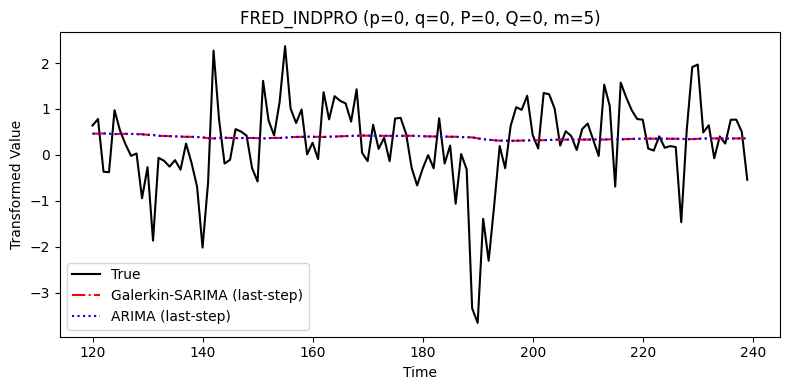

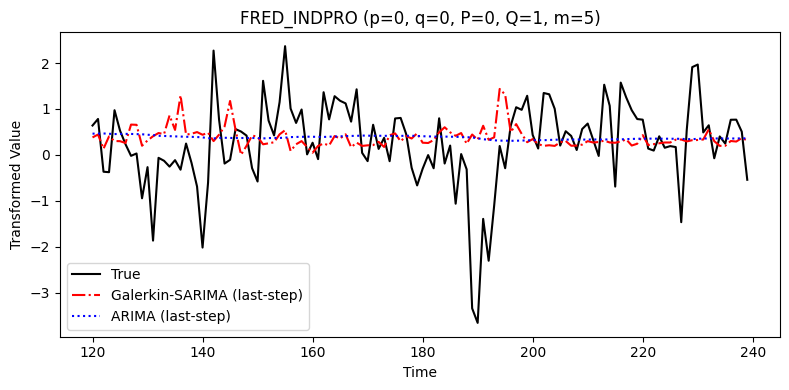

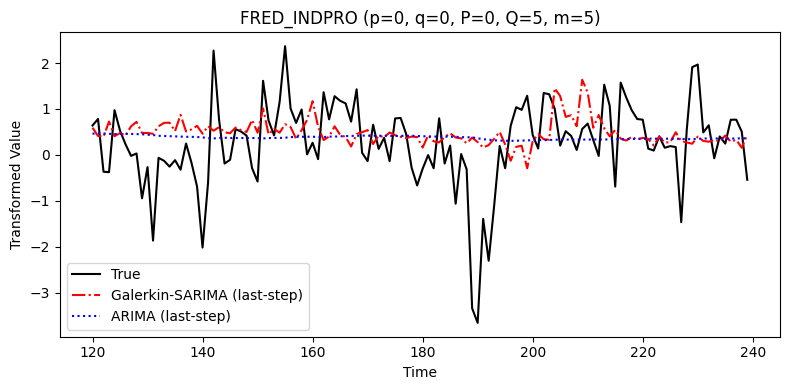

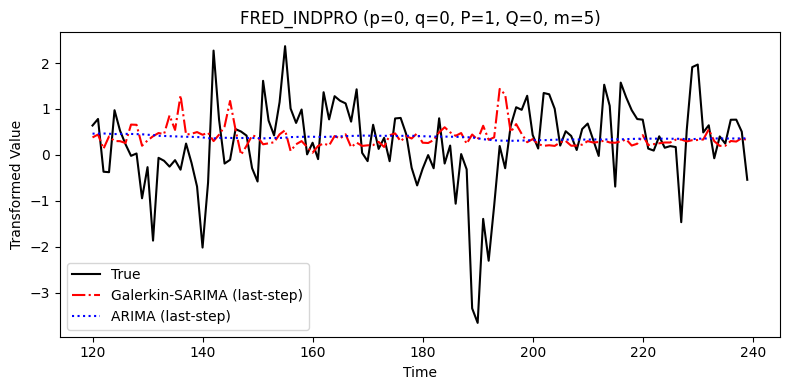

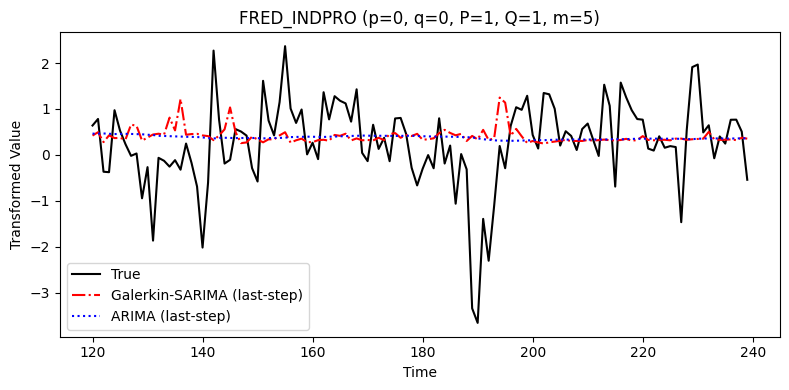

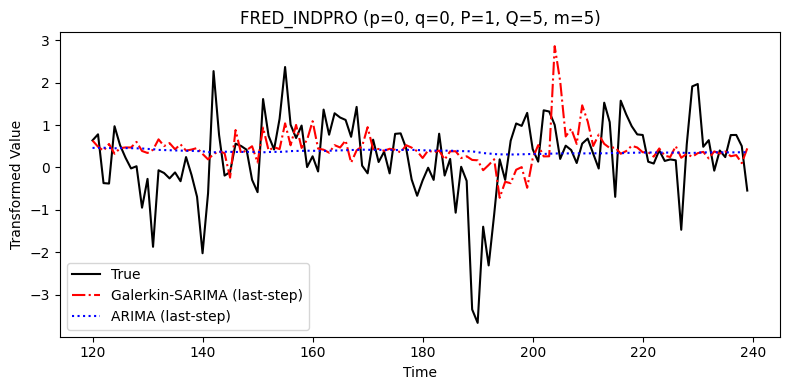

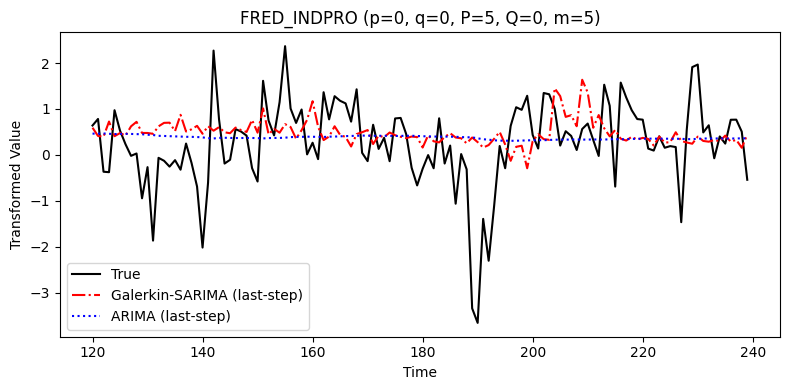

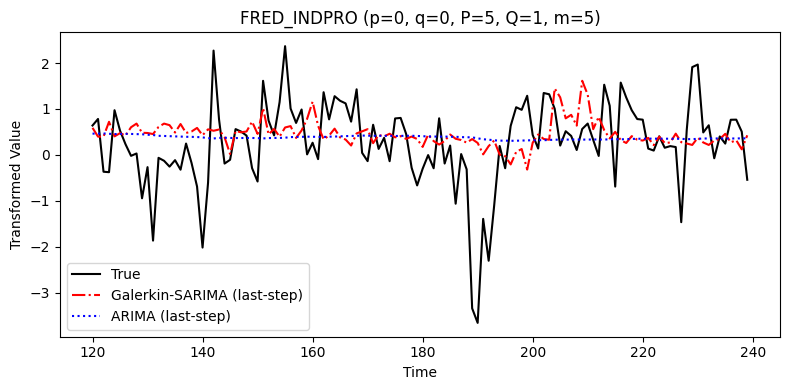

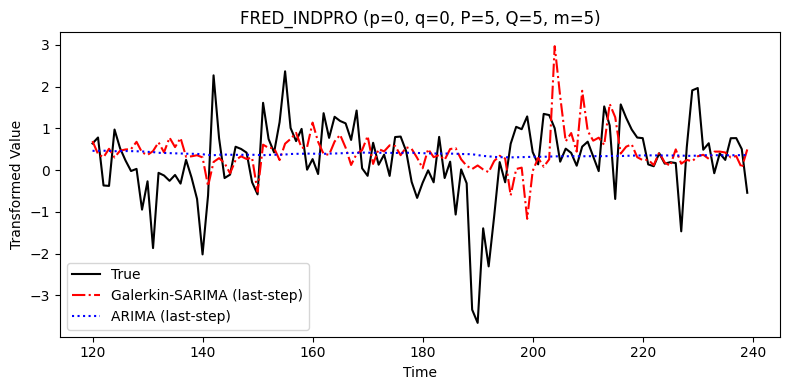

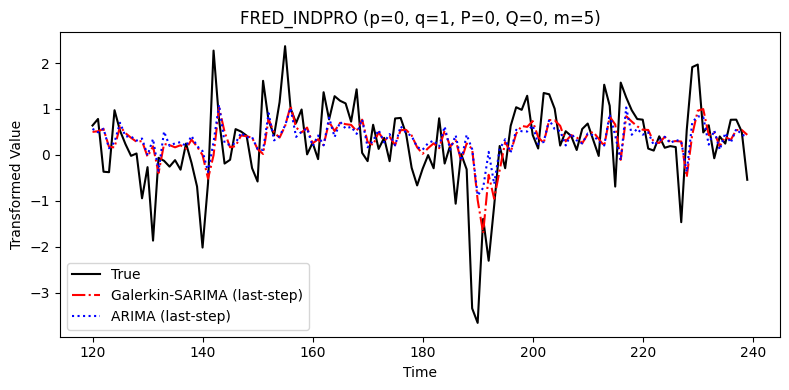

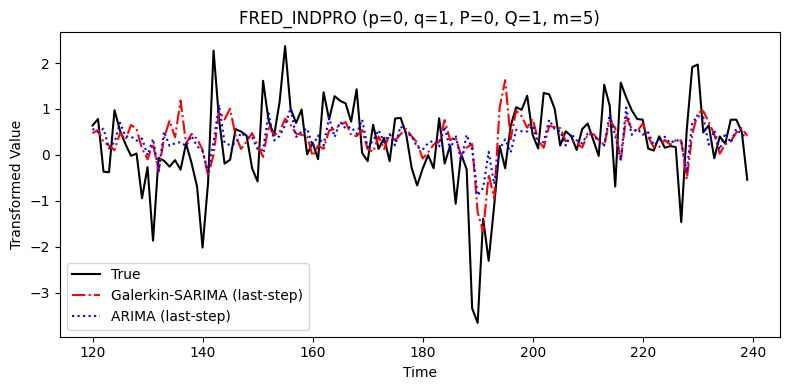

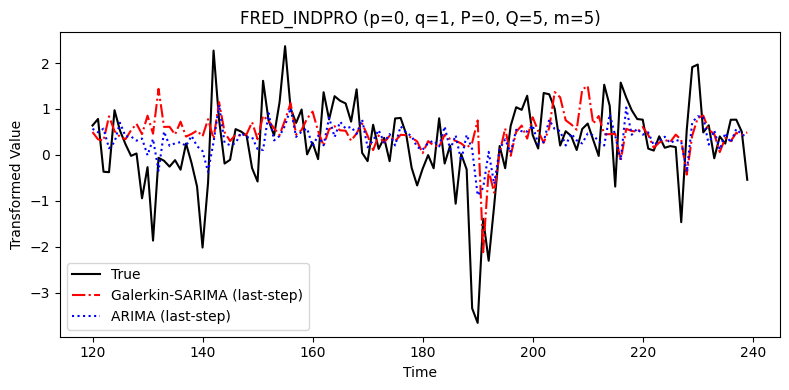

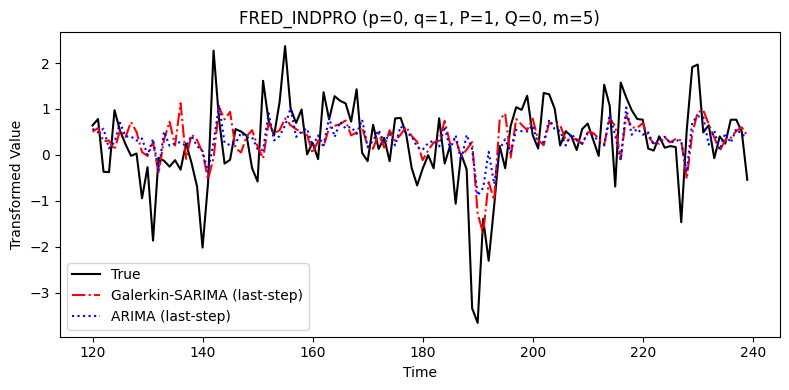

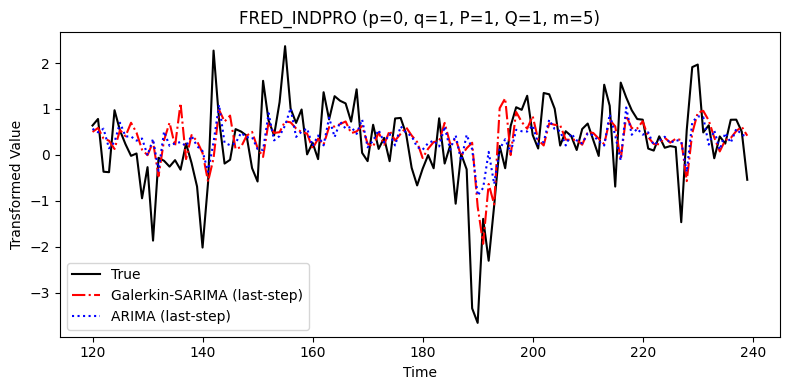

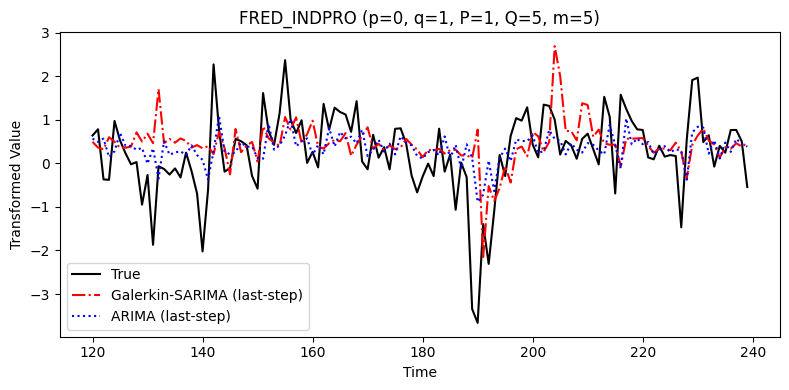

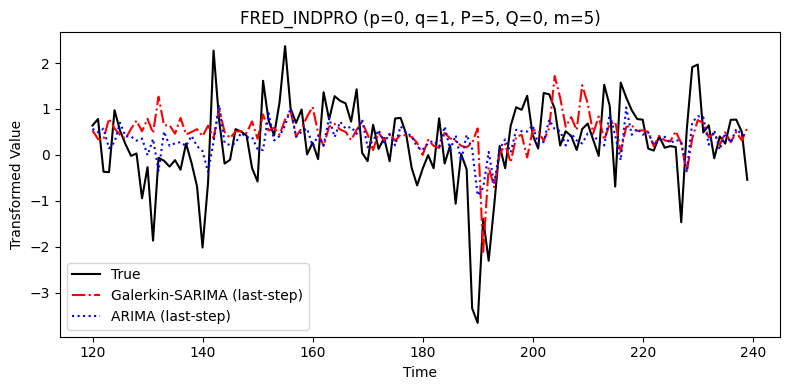

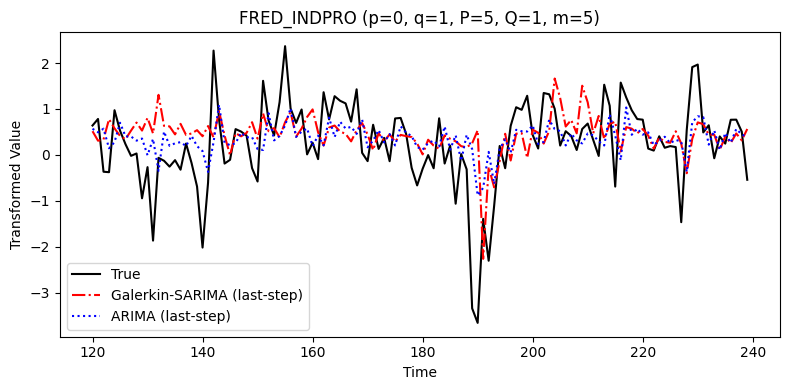

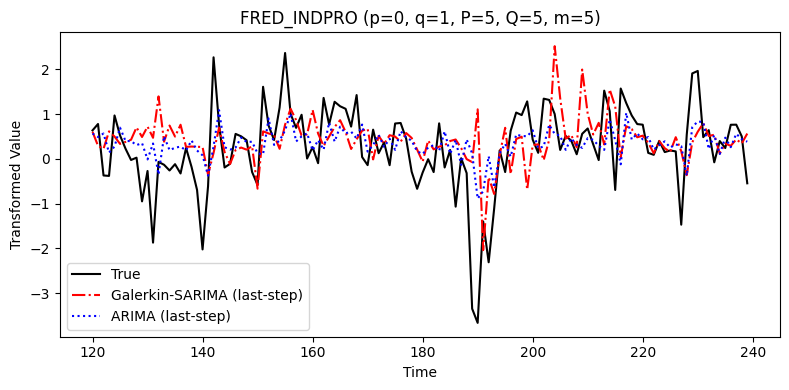

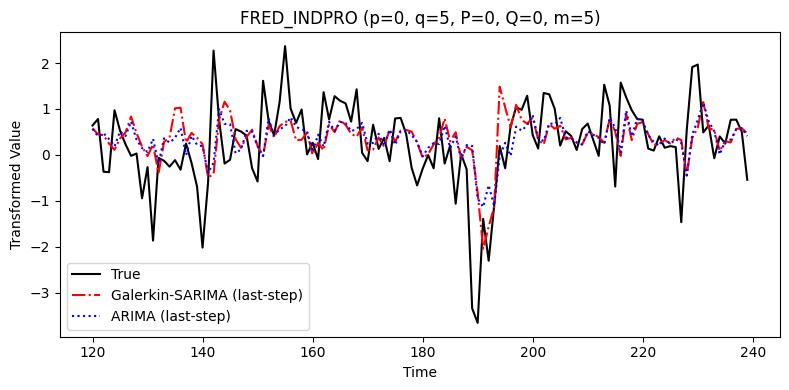

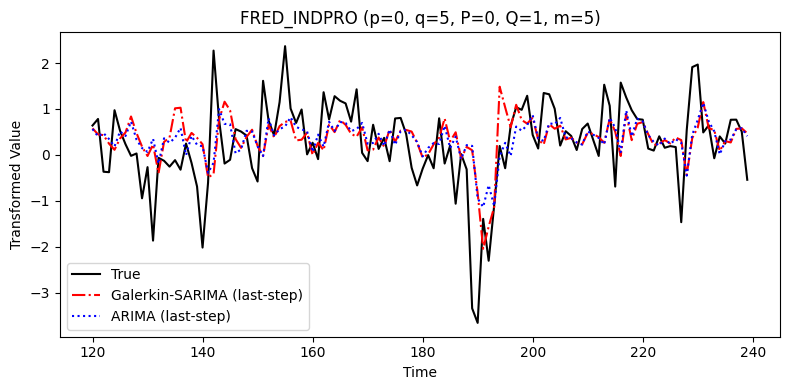

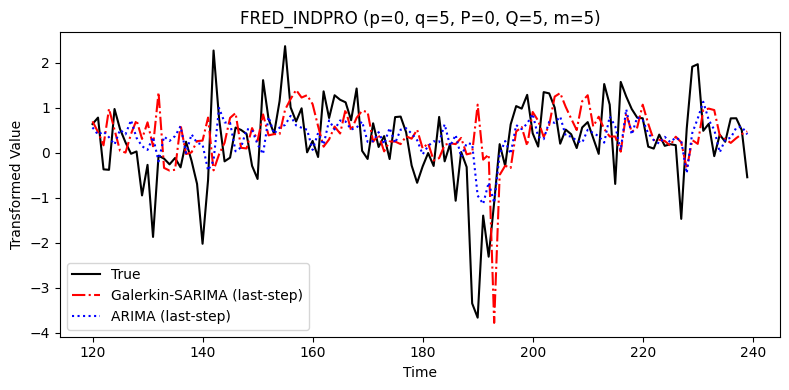

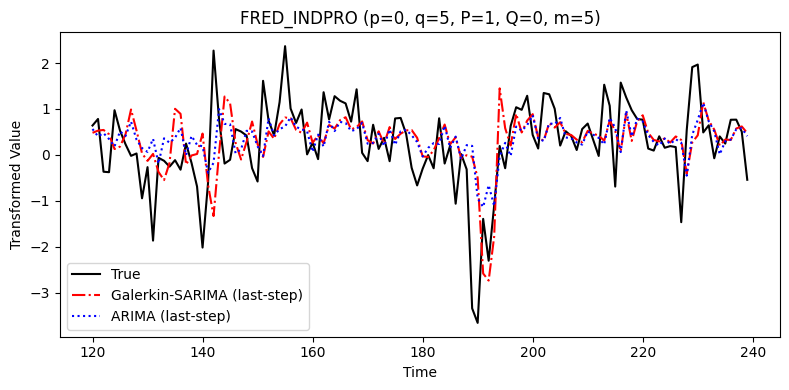

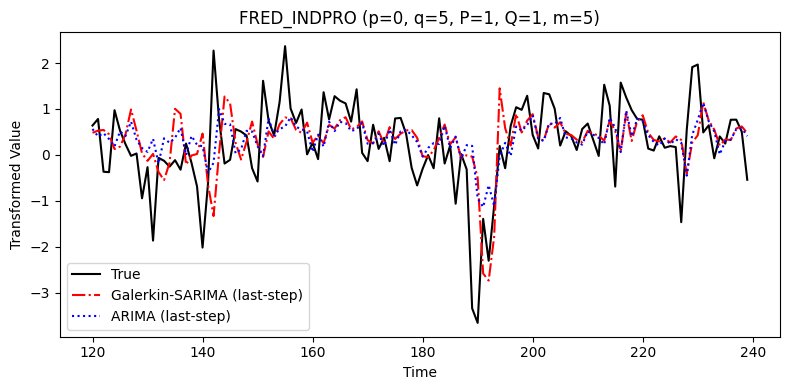

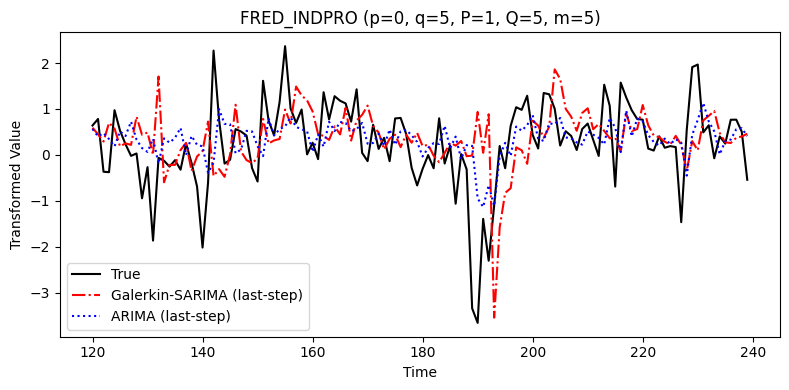

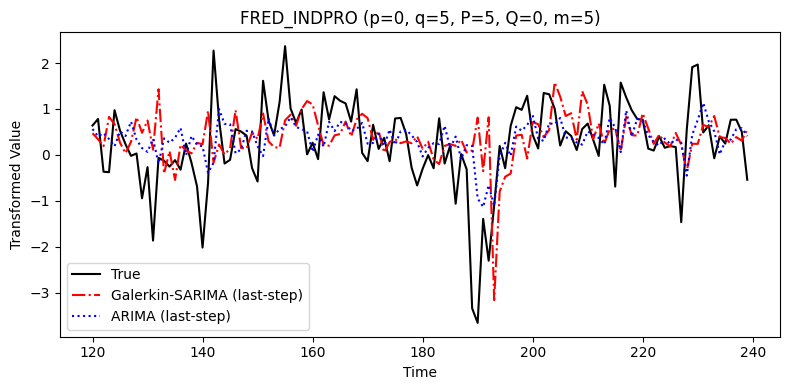

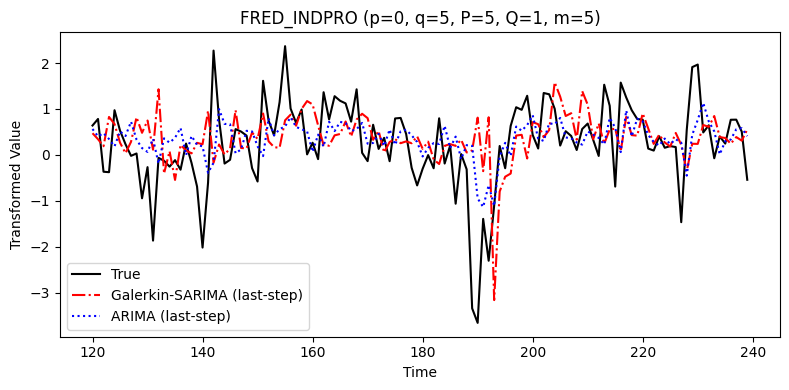

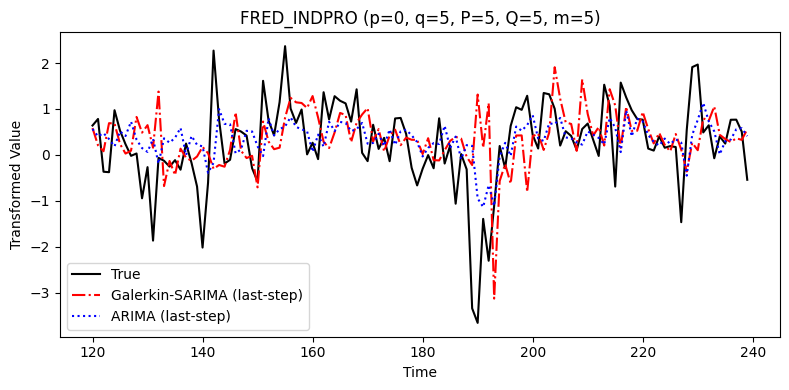

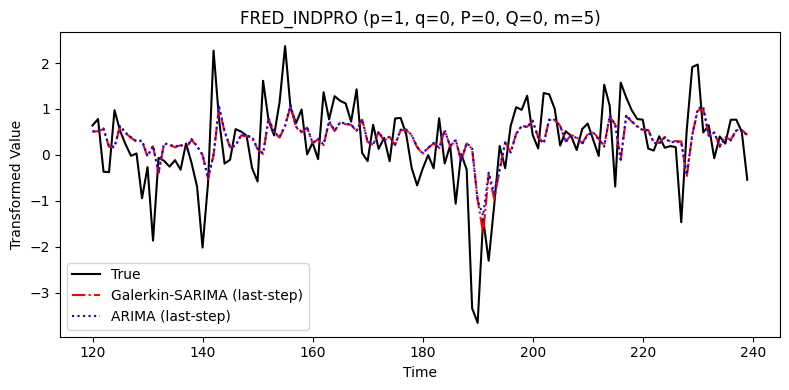

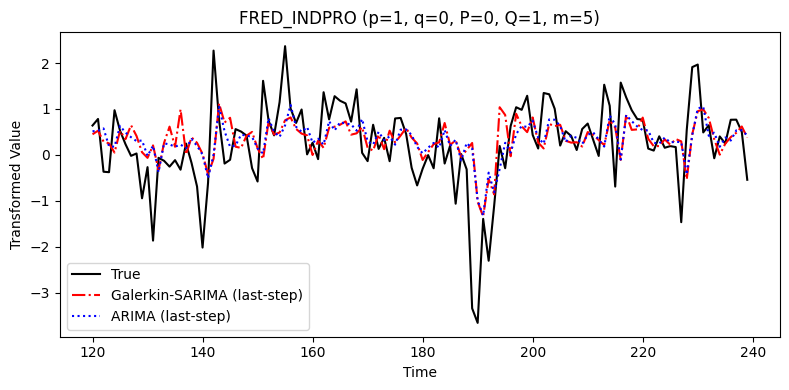

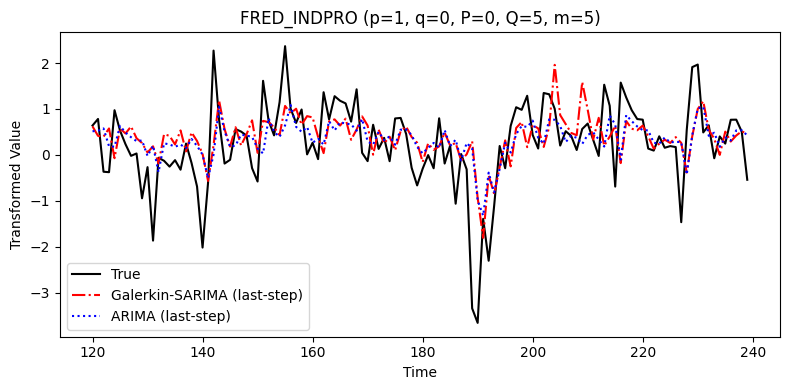

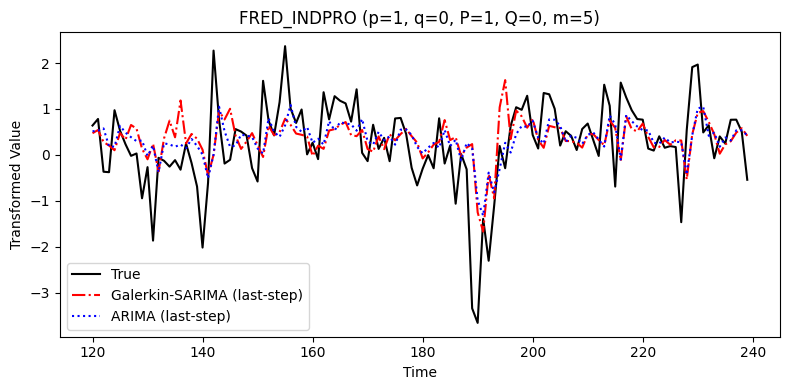

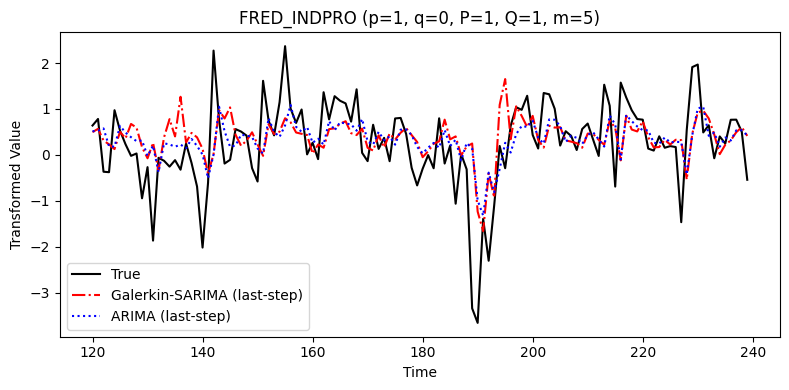

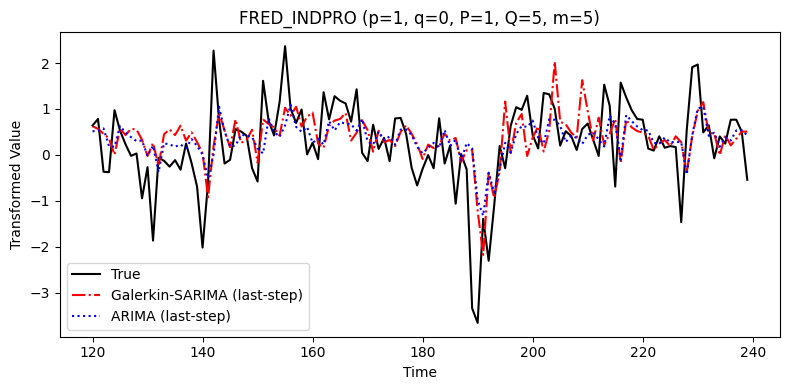

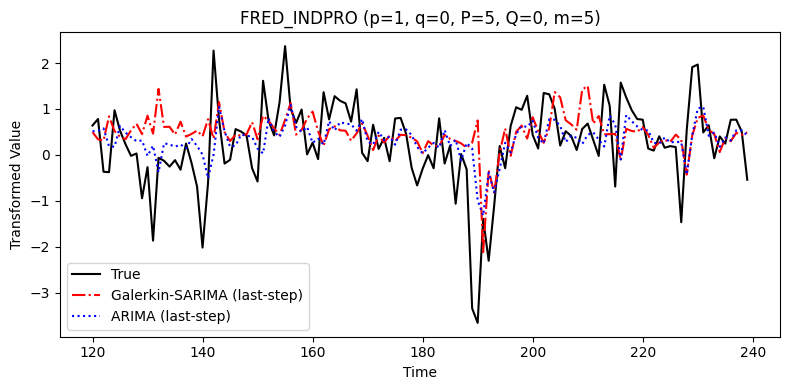

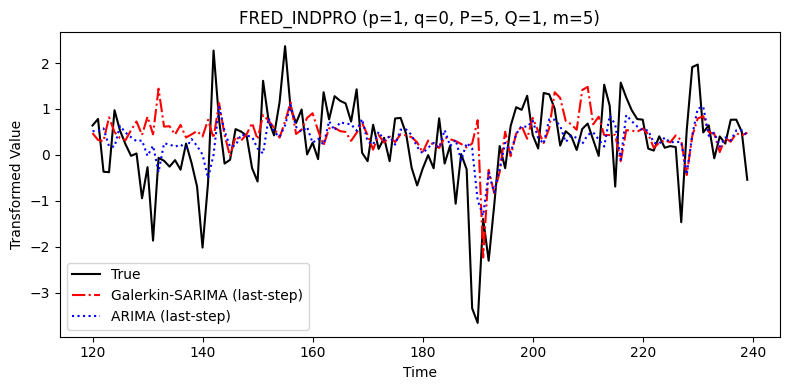

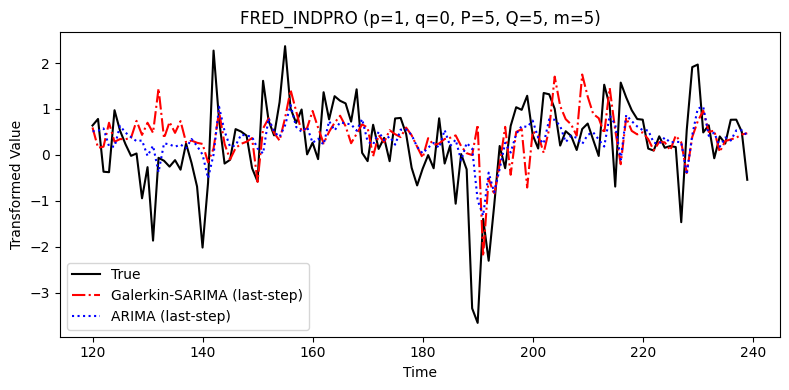

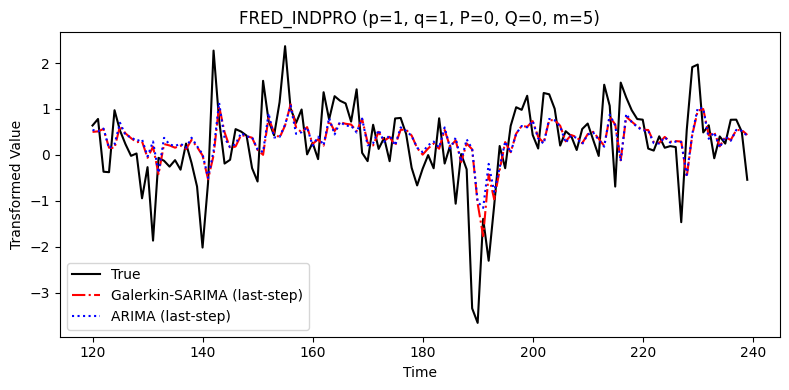

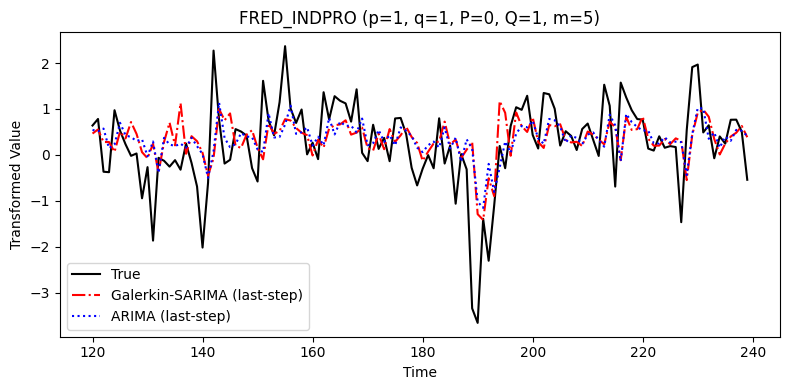

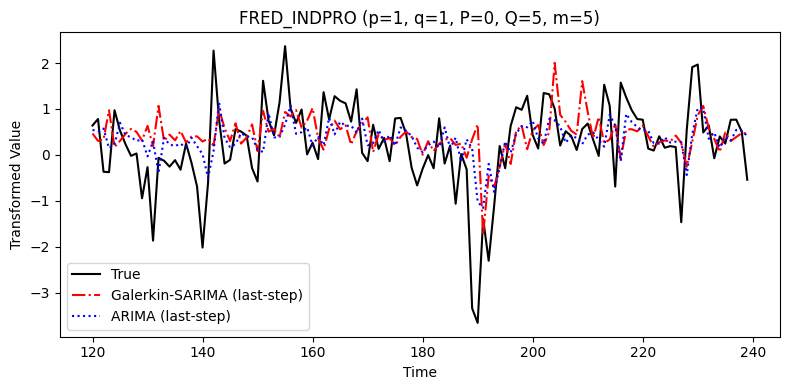

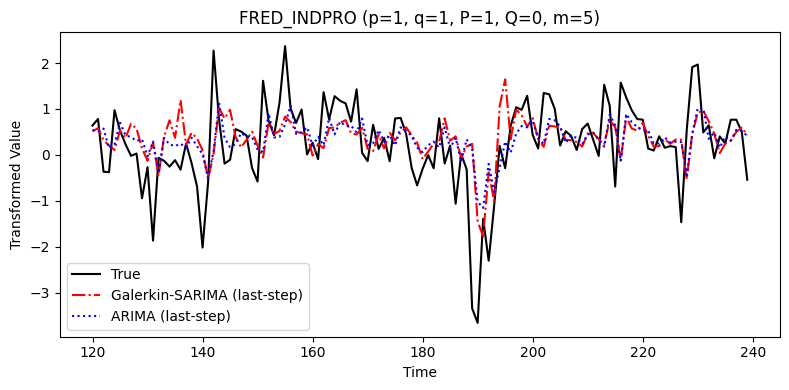

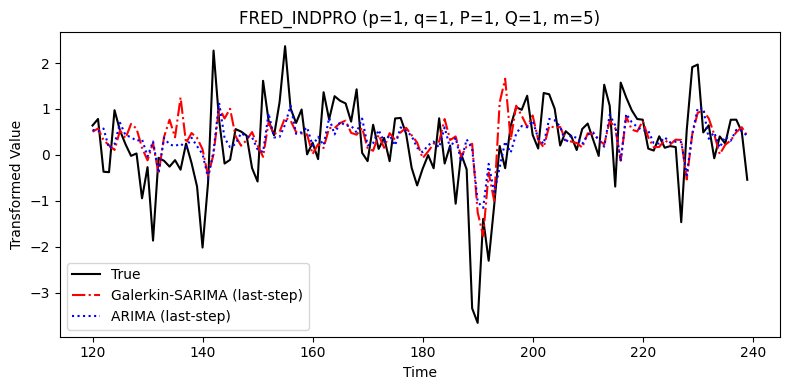

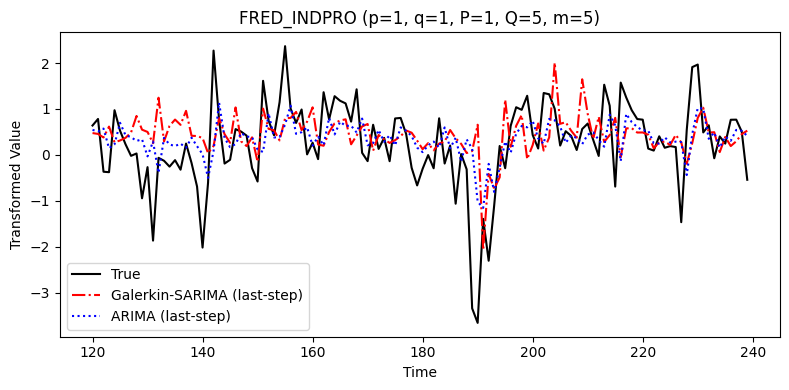

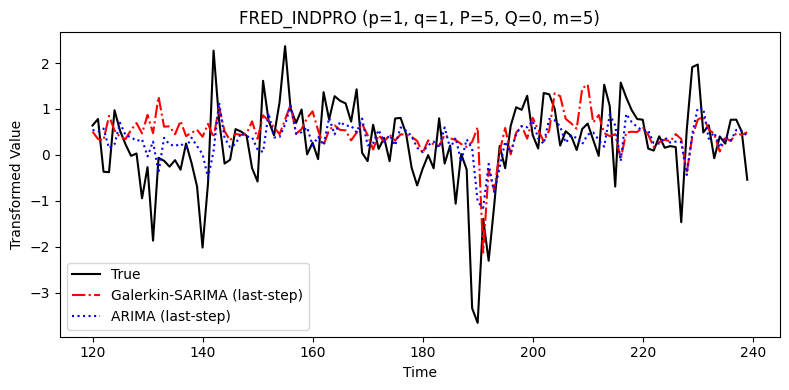

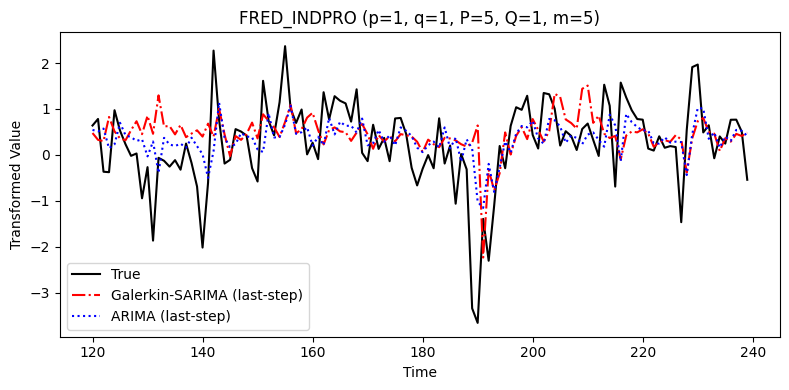

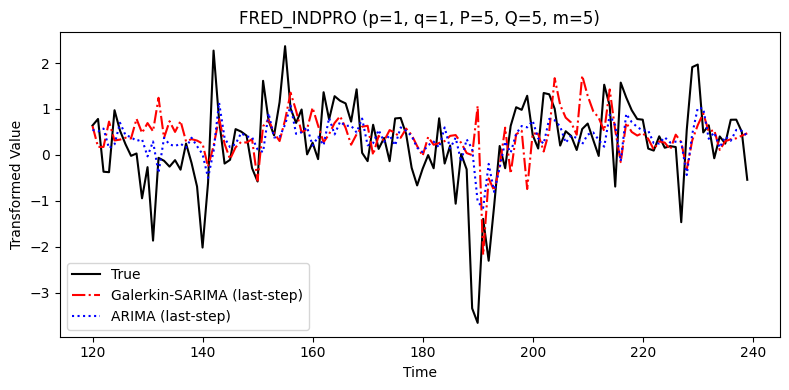

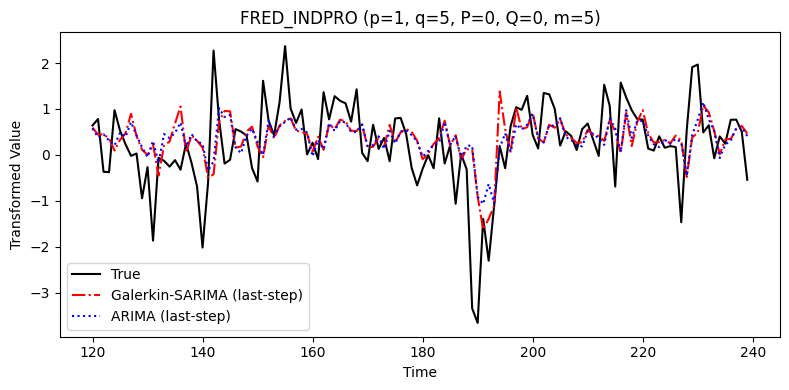

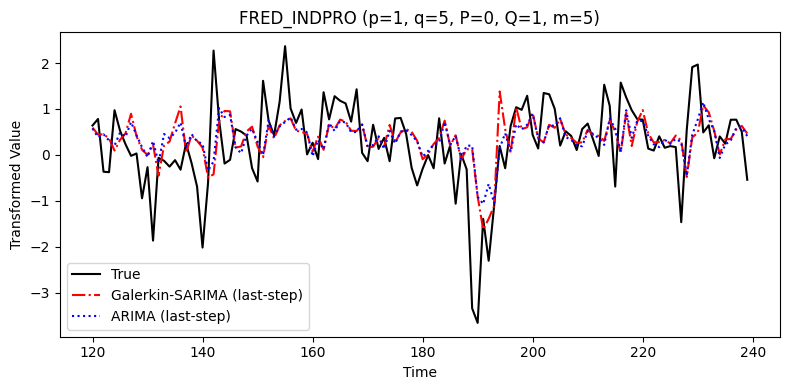

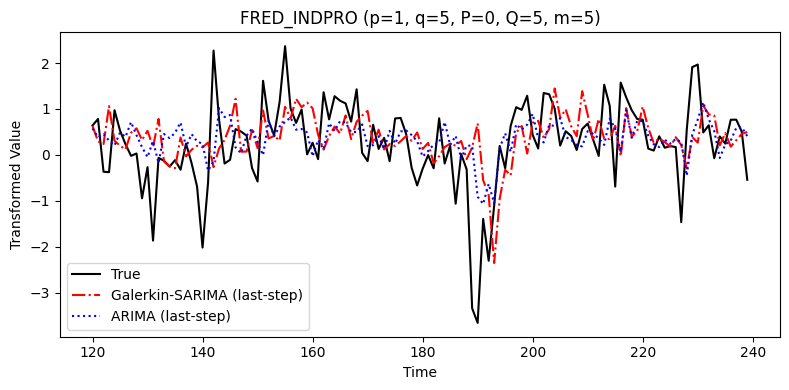

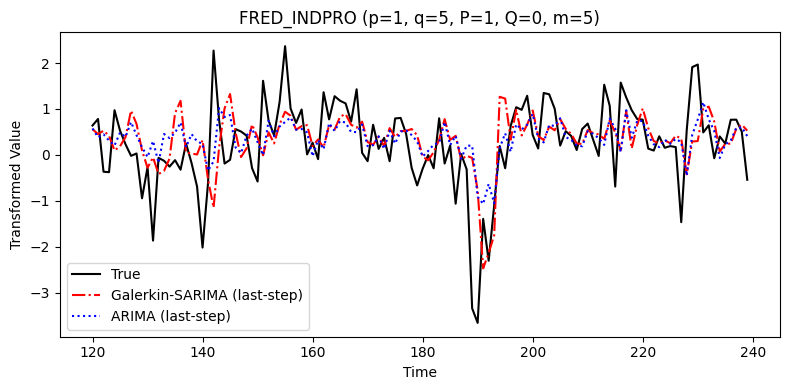

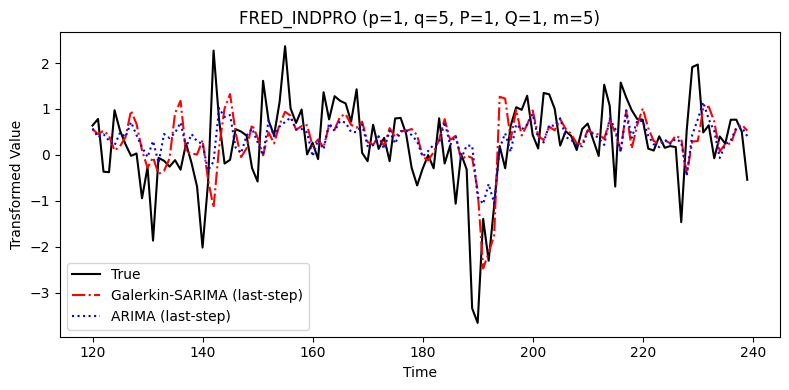

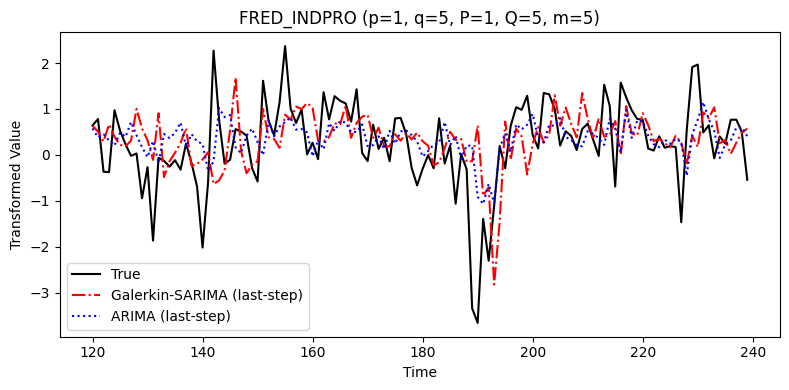

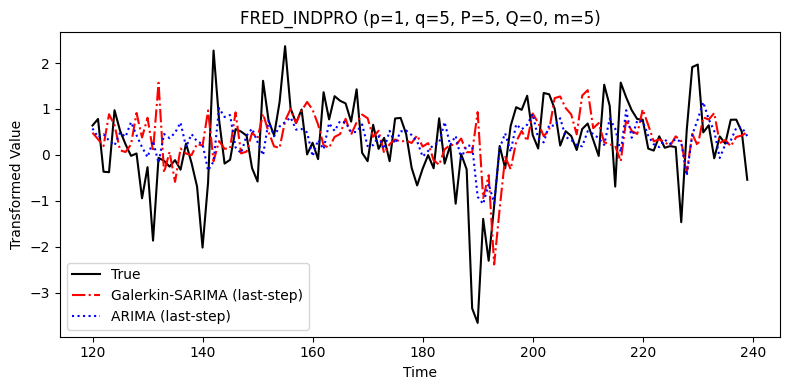

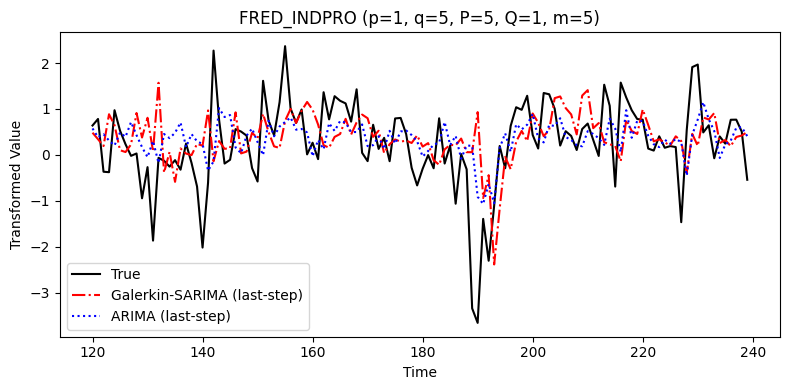

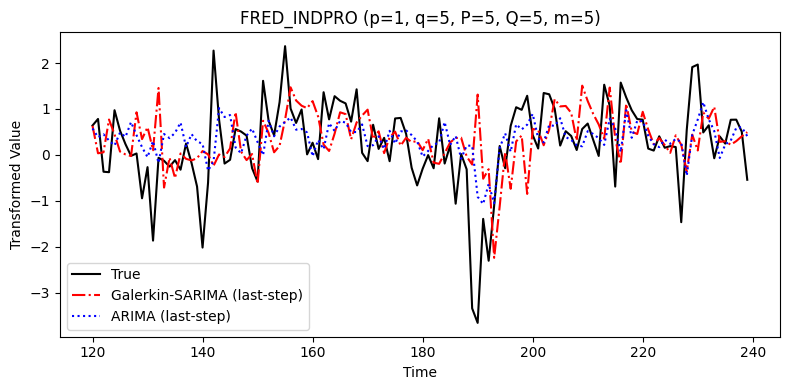

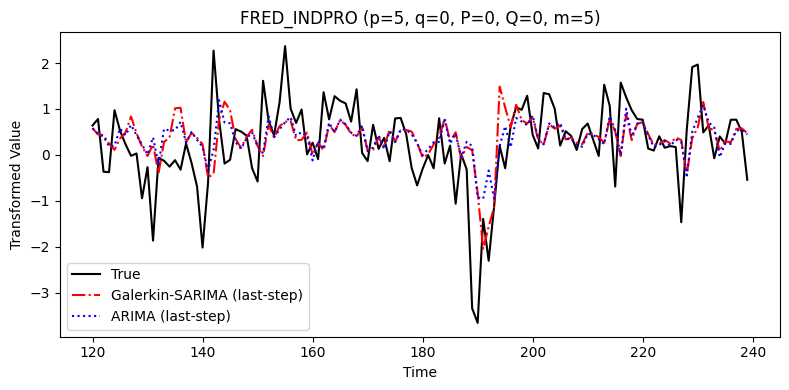

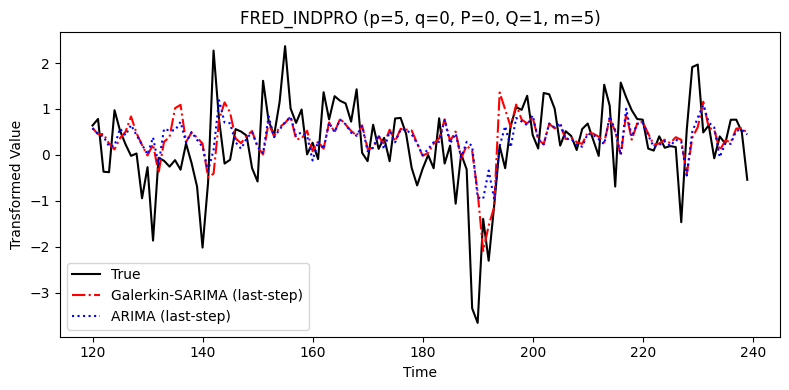

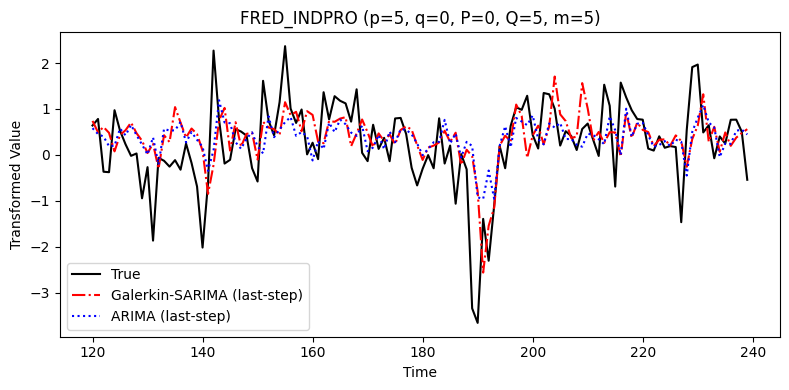

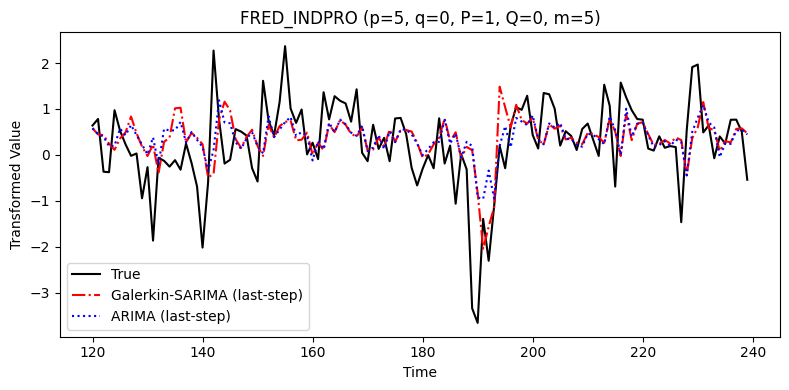

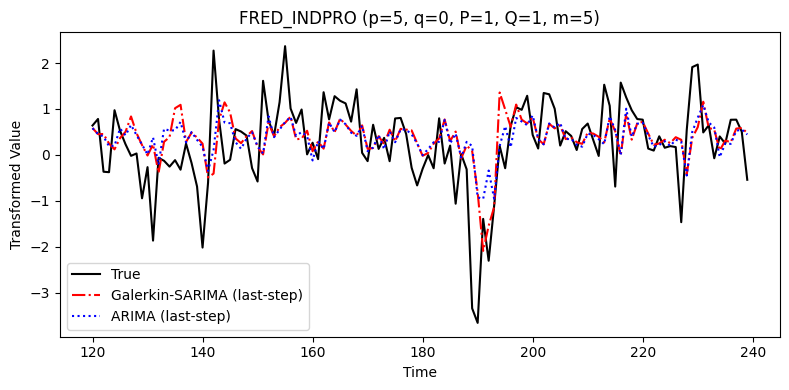

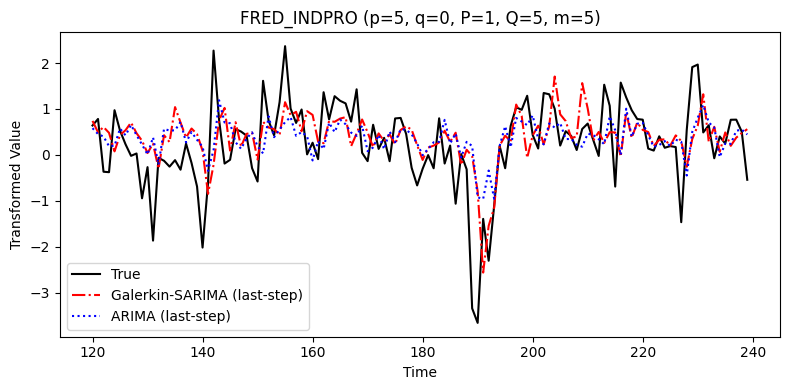

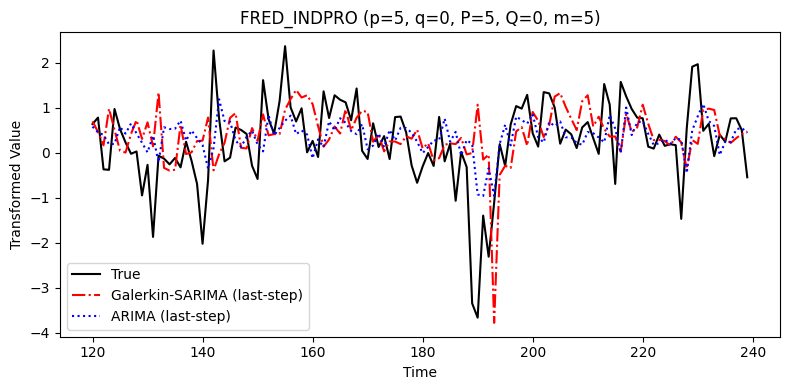

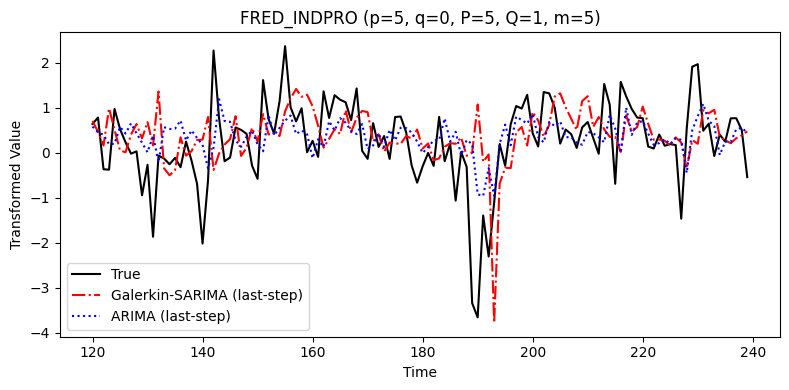

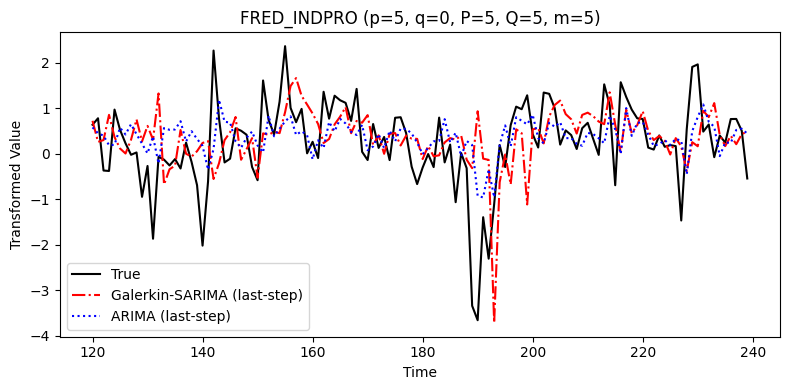

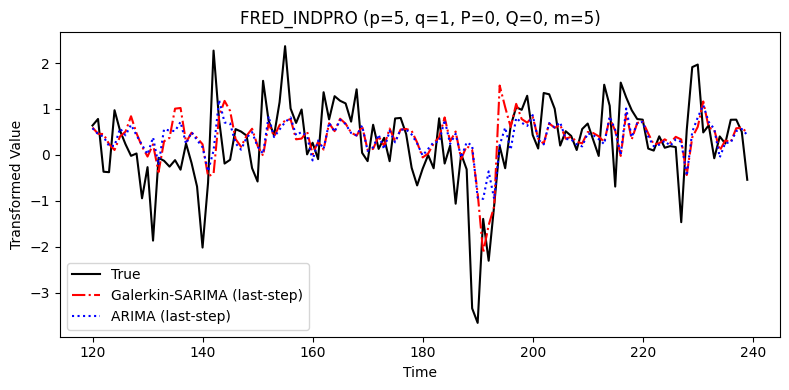

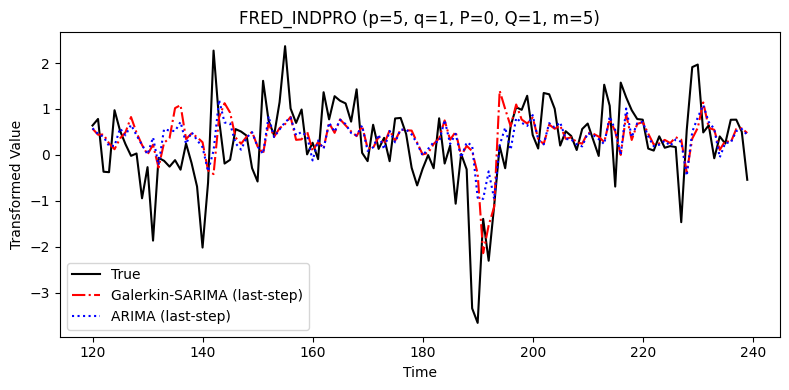

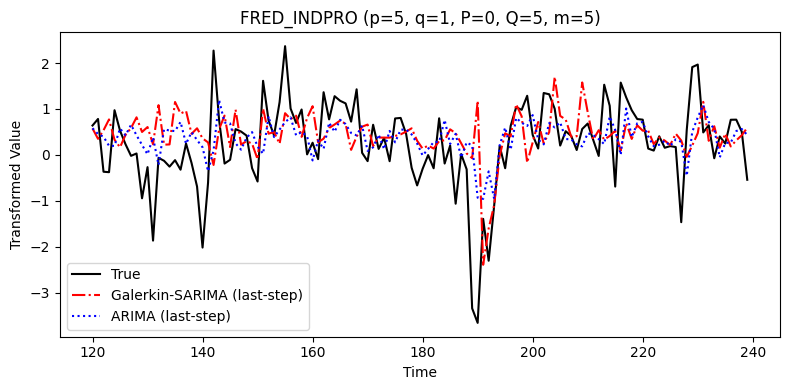

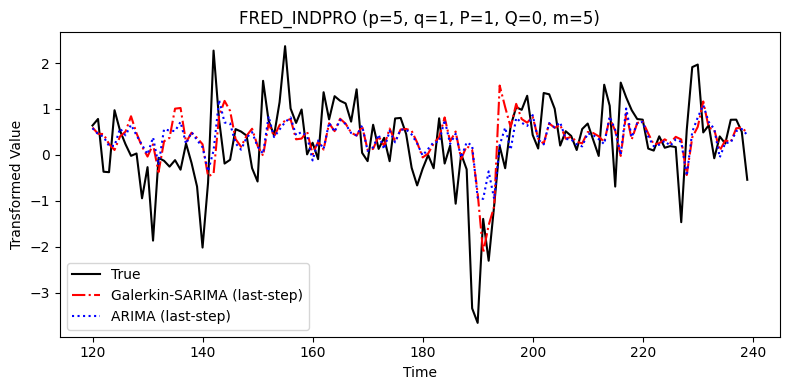

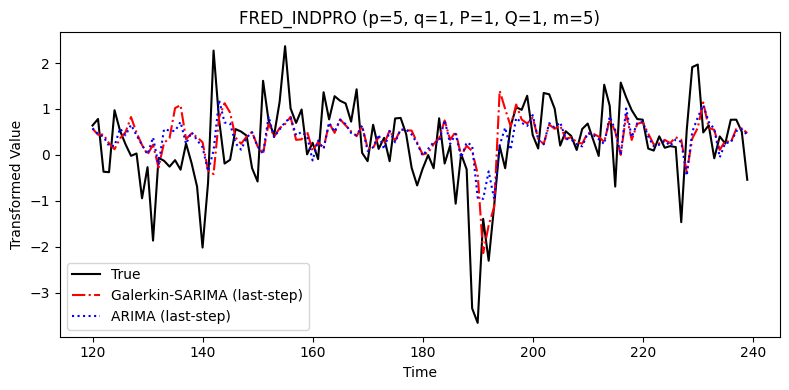

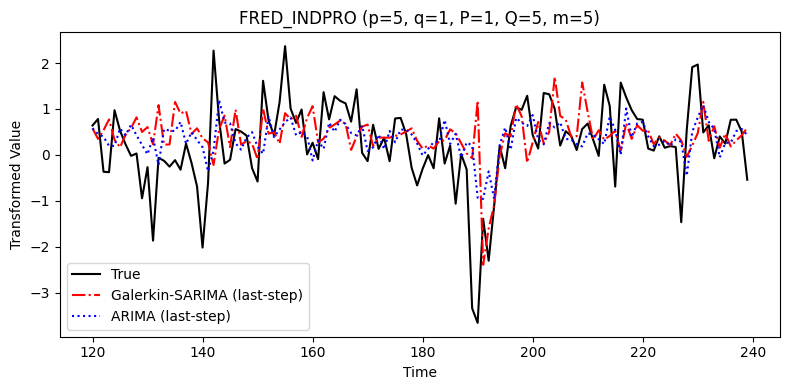

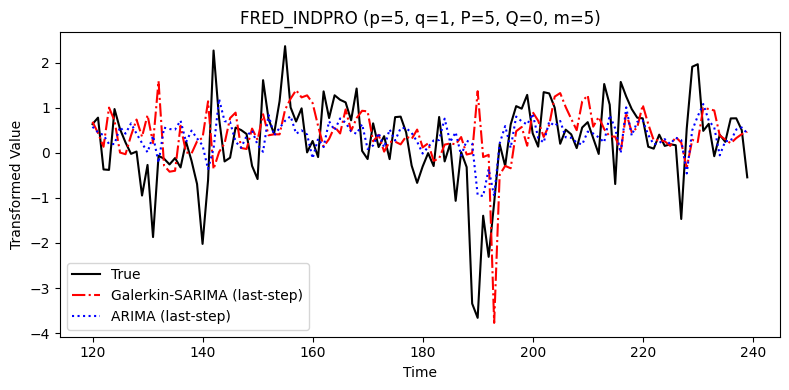

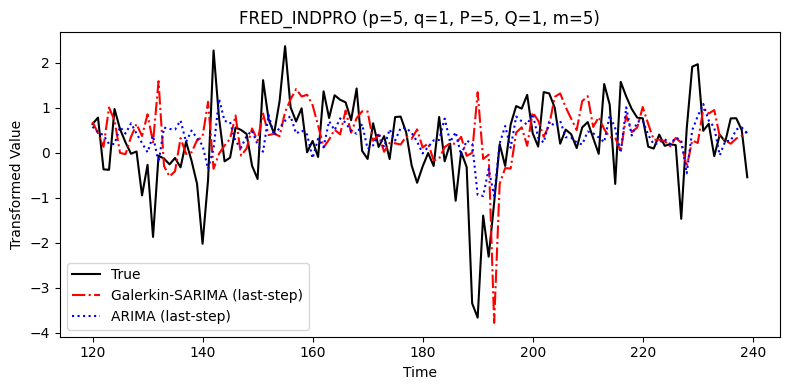

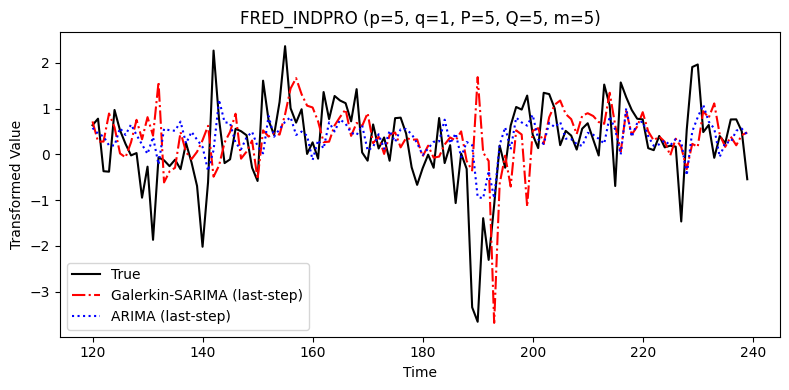

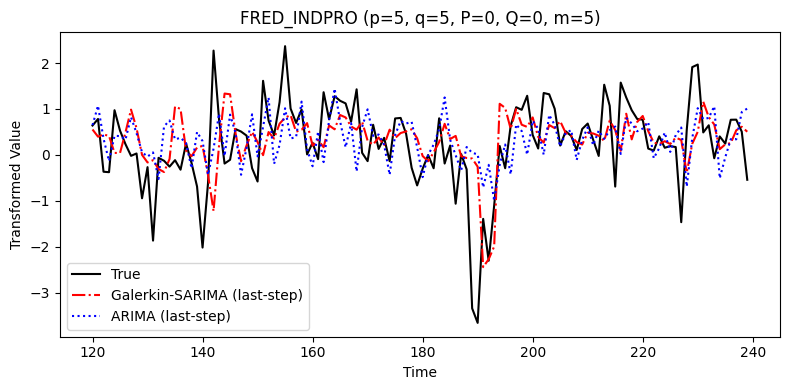

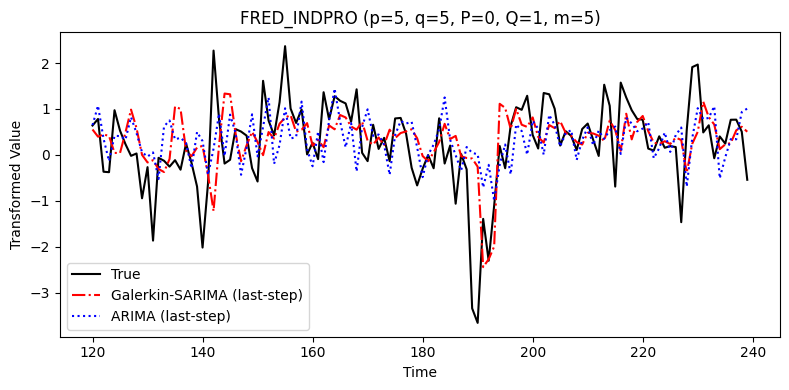

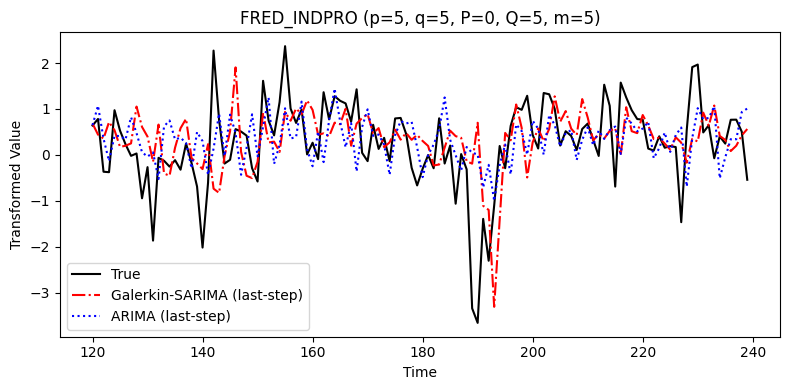

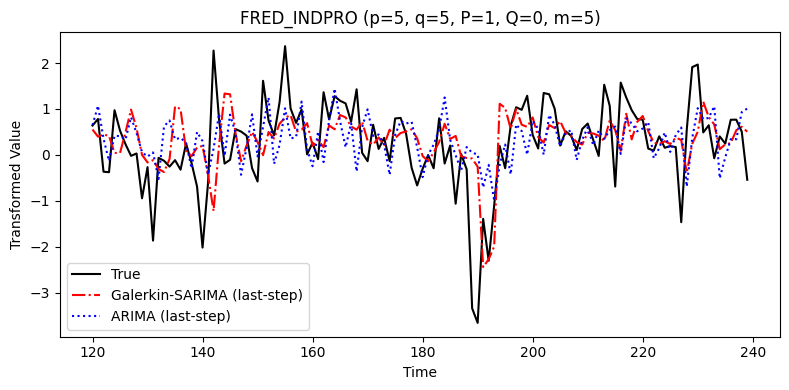

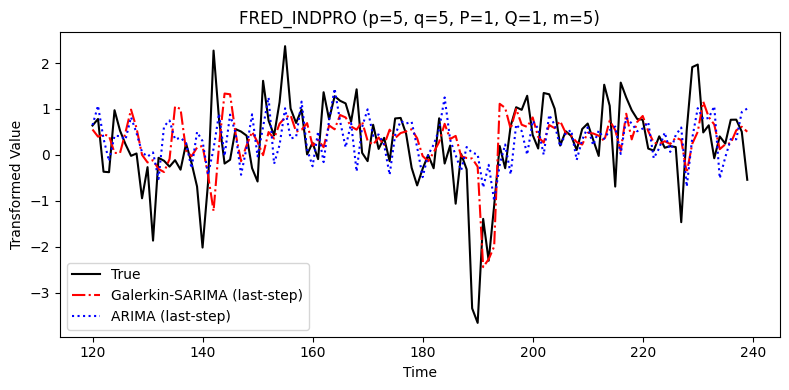

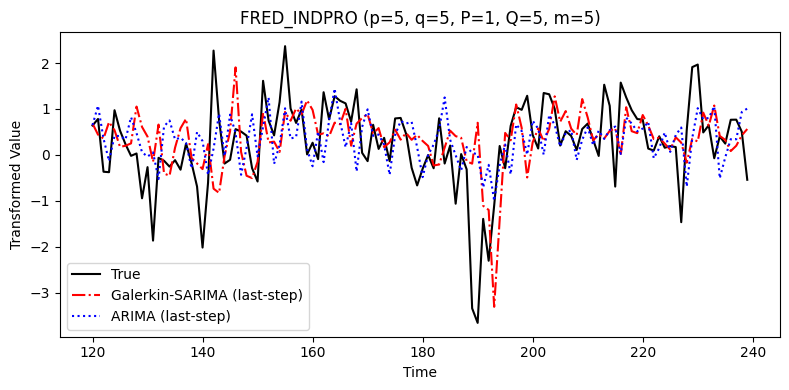

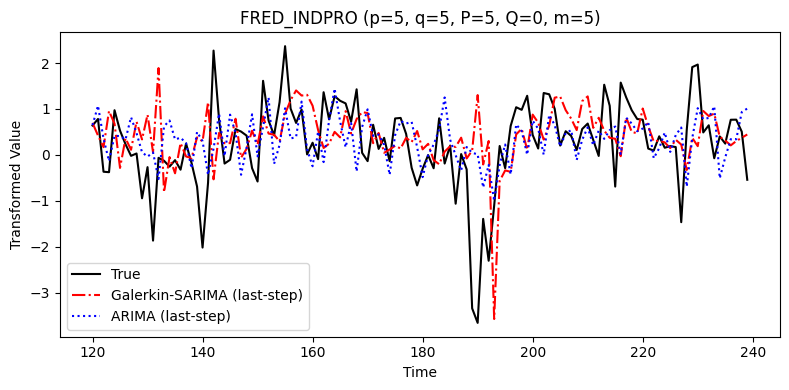

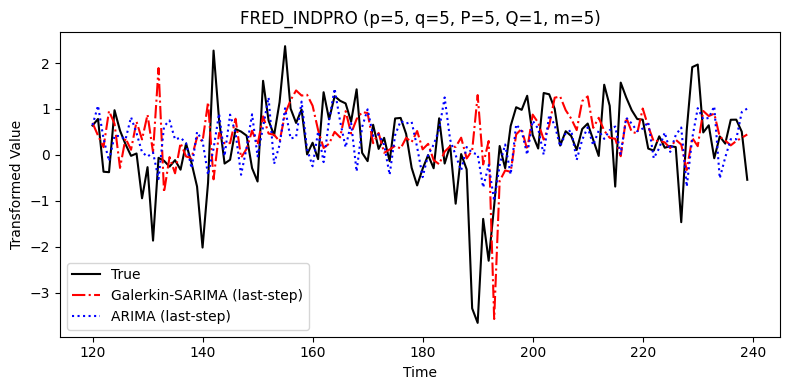

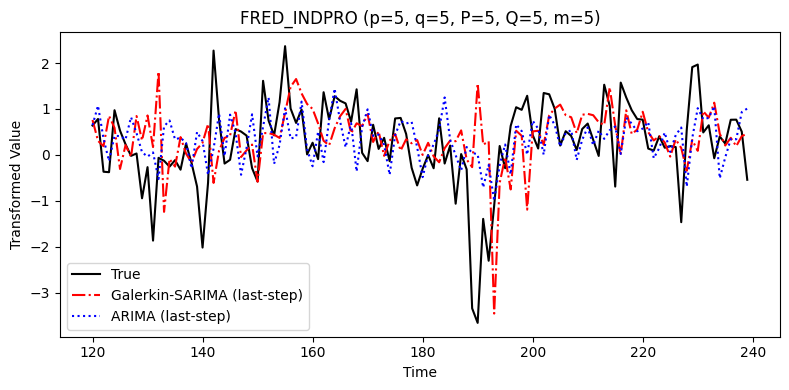

In [14]:

for name, series in datasets.items():
    for p, q, P, Q in orders:
        y_true = series[window:window + horizon]
        sg = first_run_preds_g[(name, p, q, P, Q)]
        sa = first_run_preds_a[(name, p, q, P, Q)]
        plt.figure(figsize=(8, 4))
        plt.plot(range(window, window + horizon), y_true, 'k-', label='True')
        plt.plot(range(window, window + horizon), sg, 'r-.', label='Galerkin-SARIMA (last-step)')
        plt.plot(range(window, window + horizon), sa, 'b:', label='ARIMA (last-step)')
        plt.title(f"{name} (p={p}, q={q}, P={P}, Q={Q}, m={m_seasonal})")
        plt.xlabel("Time")
        plt.ylabel("Transformed Value")
        plt.legend()
        plt.tight_layout()
        plt.show()